Step 2: Exploratory Data Analysis (EDA)

Objective: Load the dataset paths into a structured DataFrame, analyze the
class distribution, and visualize sample images to understand the data.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image

In [33]:
# --- Configuration ---
# This is the base path from your screenshot
BASE_PATH = '../data/plantvillage_raw/New Plant Diseases Dataset(Augmented)'
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
VALID_PATH = os.path.join(BASE_PATH, 'valid')
# Path for the test folder, which is one level up
RAW_DATA_PATH = '../data/plantvillage_raw'
TEST_PATH = os.path.join(RAW_DATA_PATH, 'test')

In [34]:
# --- Helper Function ---
def create_dataframe(directory):
    """Scans a directory and returns a DataFrame of filepaths and labels."""
    filepaths = []
    labels = []
    for dirpath, _, filenames in os.walk(directory):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            label = os.path.basename(dirpath)
            filepaths.append(filepath)
            labels.append(label)
    return pd.DataFrame({'filepath': filepaths, 'label': labels})

In [35]:
# --- Main Execution ---
# Create DataFrames for each split
train_df = create_dataframe(TRAIN_PATH)
val_df = create_dataframe(VALID_PATH)
test_df = create_dataframe(TEST_PATH)

In [36]:
# --- Verification ---
print("--- Data Loading Verification ---")
print(f"Training set size: {len(train_df)} images")
print(f"Validation set size: {len(val_df)} images")
print(f"Test set size: {len(test_df)} images")
print("\nFirst 5 rows of the Training DataFrame:")
print(train_df.head())

--- Data Loading Verification ---
Training set size: 70295 images
Validation set size: 17572 images
Test set size: 33 images

First 5 rows of the Training DataFrame:
                                            filepath               label
0  ../data/plantvillage_raw/New Plant Diseases Da...  Apple___Apple_scab
1  ../data/plantvillage_raw/New Plant Diseases Da...  Apple___Apple_scab
2  ../data/plantvillage_raw/New Plant Diseases Da...  Apple___Apple_scab
3  ../data/plantvillage_raw/New Plant Diseases Da...  Apple___Apple_scab
4  ../data/plantvillage_raw/New Plant Diseases Da...  Apple___Apple_scab



--- Training Set Analysis ---


C:\Users\Punith\AppData\Local\Temp\ipykernel_29544\3355545570.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


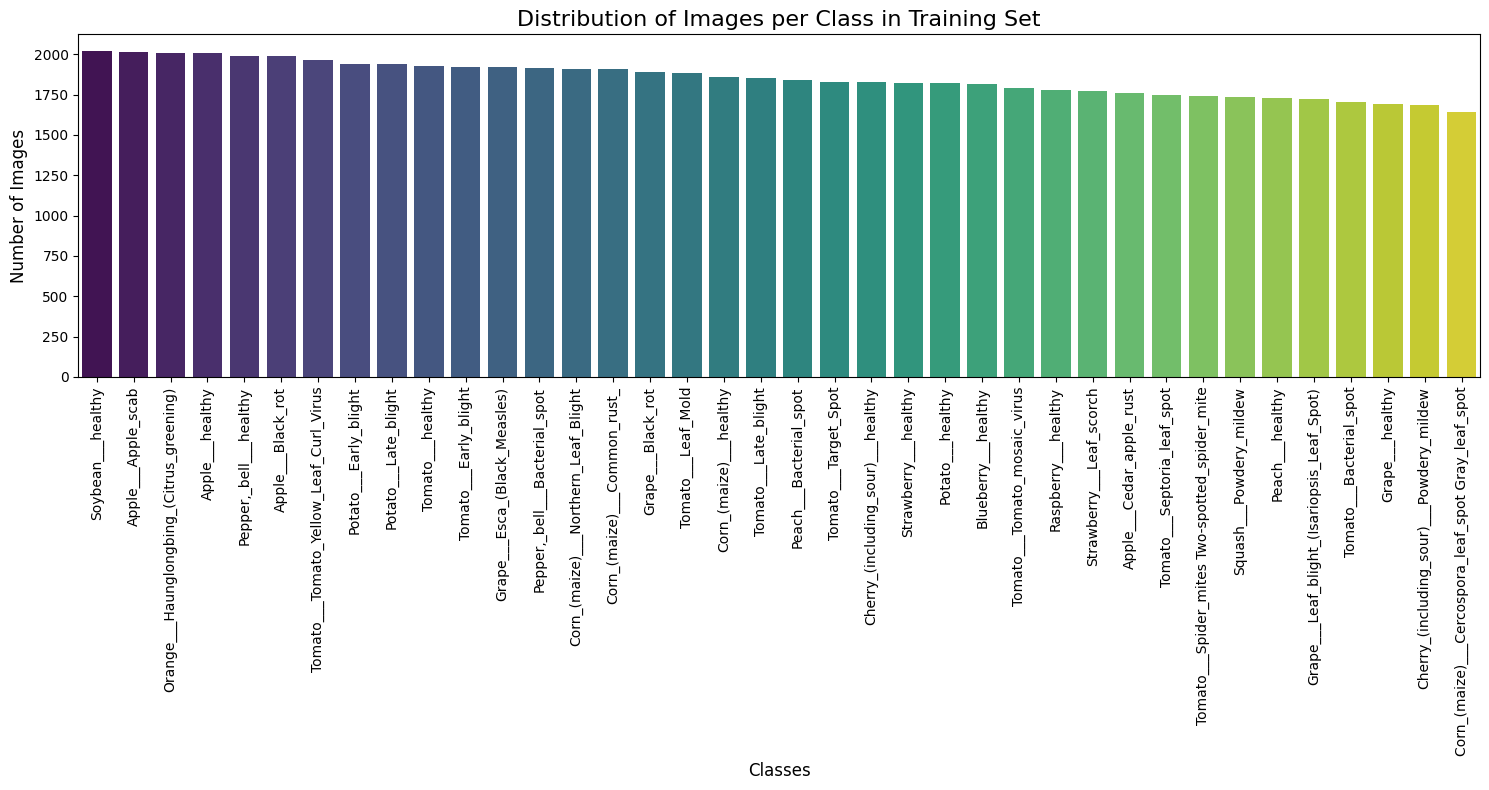

In [37]:
# --- Analyze Training Set Class Distribution ---
print("\n--- Training Set Analysis ---")
class_counts = train_df['label'].value_counts()

plt.figure(figsize=(15, 8))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Distribution of Images per Class in Training Set', fontsize=16)
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

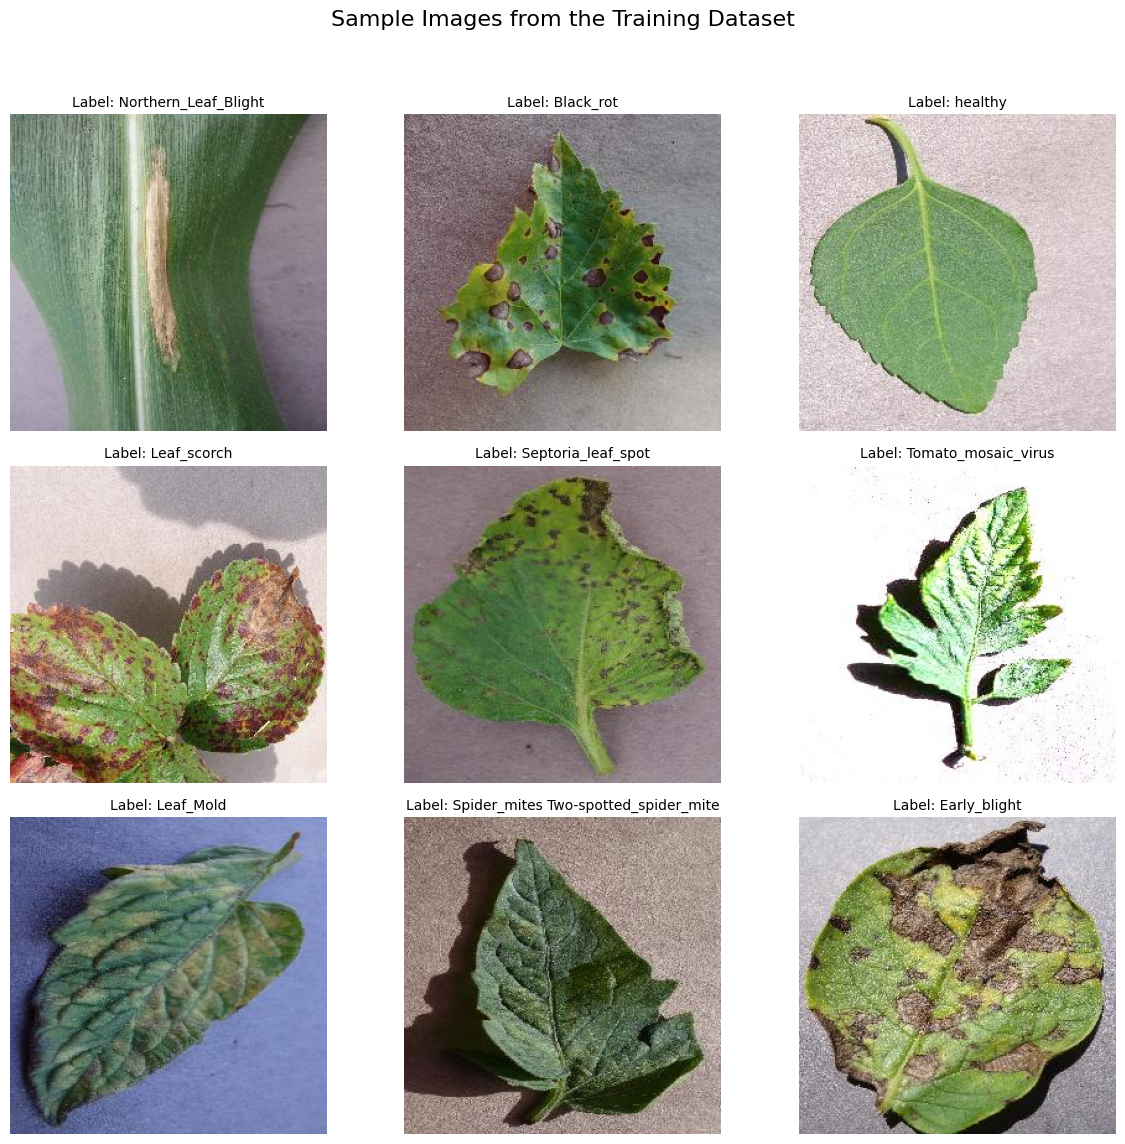

In [38]:
# --- Visualize Sample Images from the Training Set ---
sample_df = train_df.sample(9, random_state=42)

plt.figure(figsize=(12, 12))
plt.suptitle('Sample Images from the Training Dataset', fontsize=16)

for i, row in enumerate(sample_df.itertuples(), 1):
    plt.subplot(3, 3, i)
    img = Image.open(row.filepath)
    plt.imshow(img)
    plt.title(f"Label: {row.label.split('___')[1]}", fontsize=10)
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Preparing Data for PyTorch

In [39]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm  
import time

In [40]:
# --- Configuration ---
IMAGE_SIZE = 224
BATCH_SIZE = 32
NORMALIZE_MEAN = [0.485, 0.456, 0.406]
NORMALIZE_STD = [0.229, 0.224, 0.225]

In [41]:
# --- 1. Define Transformations ---
print("Step 2.C: Defining image transformations...")
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)
])
print("Transformations defined successfully.\n")

Step 2.C: Defining image transformations...
Transformations defined successfully.



In [42]:
# --- 2. Define Custom Dataset Class ---
print("Step 2: Defining custom PyTorch Dataset class...")


class PlantVillageDataset(Dataset):
    def __init__(self, dataframe, class_to_idx_map, transform=None):
        self.df = dataframe
        self.transform = transform
        self.class_to_idx_map = class_to_idx_map

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # This part is executed by multiple workers in the background
        # for each image in a batch.
        image_path = self.df.iloc[idx]['filepath']
        label_str = self.df.iloc[idx]['label']
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label_idx = self.class_to_idx_map[label_str]
        return image, label_idx


print("Dataset class defined successfully.\n")

Step 2: Defining custom PyTorch Dataset class...
Dataset class defined successfully.



In [43]:
# --- 3. Create Mappings and Datasets ---
print("Step 2.C: Creating class-to-index mappings and instantiating Datasets...")
# Use the training set to define the class-to-index mapping
class_to_idx = {label: i for i, label in enumerate(train_df['label'].unique())}
idx_to_class = {i: label for label, i in class_to_idx.items()}

train_dataset = PlantVillageDataset(
    train_df, class_to_idx, transform=train_transforms)
val_dataset = PlantVillageDataset(
    val_df, class_to_idx, transform=val_test_transforms)
test_dataset = PlantVillageDataset(
    test_df, class_to_idx, transform=val_test_transforms)
print(
    f"Datasets instantiated successfully. Number of classes: {len(class_to_idx)}\n")

# --- 4. Create DataLoaders ---
print("Step 2.C: Instantiating DataLoaders...")
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
print("DataLoaders instantiated successfully.\n")

Step 2.C: Creating class-to-index mappings and instantiating Datasets...
Datasets instantiated successfully. Number of classes: 38

Step 2.C: Instantiating DataLoaders...
DataLoaders instantiated successfully.



In [44]:
# --- 5. Verification with Progress Bar ---
print("--- Verifying DataLoader Performance ---")
print("Fetching the first batch... This can be slow as background workers start up.")
start_time = time.time()

# Wrap the data loader with tqdm to get a progress bar
progress_bar = tqdm(train_loader, desc="Loading first batch")
# Get the first batch
images, labels = next(iter(progress_bar))
end_time = time.time()

# Report results
print(f"\nTime to load first batch: {end_time - start_time:.2f} seconds")
print(f"Images batch shape: {images.shape}")
print(f"Labels batch shape: {labels.shape}")
print("\nVerification complete. The progress bar shows you the data loading speed.")

--- Verifying DataLoader Performance ---
Fetching the first batch... This can be slow as background workers start up.


Loading first batch:   0%|          | 0/2197 [00:00<?, ?it/s]


Time to load first batch: 0.11 seconds
Images batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])

Verification complete. The progress bar shows you the data loading speed.


In [45]:
# --- Save the DataFrames to Prevent Re-Scanning ---

# Define a directory to store our processed data
PROCESSED_DATA_DIR = '../data/processed'
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)

# Save each dataframe to a fast-loading Parquet file
train_df.to_parquet(os.path.join(PROCESSED_DATA_DIR, 'train.parquet'))
val_df.to_parquet(os.path.join(PROCESSED_DATA_DIR, 'val.parquet'))
test_df.to_parquet(os.path.join(PROCESSED_DATA_DIR, 'test.parquet'))

print(f"DataFrames saved successfully to '{PROCESSED_DATA_DIR}'")

DataFrames saved successfully to '../data/processed'


In [46]:

# --- DEBUG CELL ---

# This should be the same path you used to create the test_df
TEST_PATH = '../data/plantvillage_raw/test'

print(f"Checking path: '{TEST_PATH}'")

# 1. Check if the directory exists
path_exists = os.path.exists(TEST_PATH)
print(f"Does this path exist? -> {path_exists}")

# 2. If it exists, check if it's empty
if path_exists:
    contents = os.listdir(TEST_PATH)
    print(f"Is the directory empty? -> {len(contents) == 0}")
    if len(contents) > 0:
        print(f"First few items in the directory: {contents[:5]}")

Checking path: '../data/plantvillage_raw/test'
Does this path exist? -> True
Is the directory empty? -> False
First few items in the directory: ['AppleCedarRust1.JPG', 'AppleCedarRust2.JPG', 'AppleCedarRust3.JPG', 'AppleCedarRust4.JPG', 'AppleScab1.JPG']
